In [1]:
import pandas as pd
from datetime import timedelta
#Data processing
from sklearn import preprocessing

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
df = pd.read_csv('../seatunnel_full.csv')

In [ ]:
df['total_time'] = pd.to_datetime(df['end_time']) - pd.to_datetime(df['begin_time'])

In [ ]:
cl = list(df['total_time'])

In [ ]:
df['total_time'] < timedelta(minutes=2)

0       False
1       False
2       False
3       False
4       False
        ...  
2092    False
2093    False
2094    False
2095    False
2096    False
Name: total_time, Length: 2097, dtype: bool

In [ ]:
df['time_binary'] = df['total_time'].apply(lambda x:  0 if x < timedelta (days = 3) else 1)

In [ ]:
X = df.loc[:, ~df.columns.isin([
    'url', 'begin_url', 'end_url',
    # 'time_binary',
    'total_time',
    'begin_sha', 'end_sha', 'begin_time', 'begin_key', 'begin_revision', 'end_time', 'end_key', 'end_revision'])]

In [ ]:
scaler = preprocessing.StandardScaler()
df_scaler = scaler.fit_transform(X)
# df_scaler_col = pd.DataFrame(df_scaler, columns=[cl])
df_scaler = df_scaler.T

In [ ]:
scaler_1 = preprocessing.MinMaxScaler()
scaler_1

MinMaxScaler()

In [ ]:
df_scaler

array([[-0.43758778, -0.43758778, -0.43758778, ...,  0.21766898,
         1.2660798 , -0.43758778],
       [-0.155264  , -0.19112028, -0.19050207, ...,  0.42152752,
         0.40112653, -0.13486302],
       [-0.10949229, -0.10875604, -0.1050748 , ...,  0.65915233,
        -0.02040609, -0.08961355],
       ...,
       [-0.44529284, -0.44529284, -0.44529284, ..., -0.44529284,
        -0.44529284, -0.44529284],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.58818055, -0.58818055, -0.58818055, ..., -0.58818055,
         1.70015824, -0.58818055]])

In [ ]:
#Silhouette analysis
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
ss = []

for i in range(2, len(df_scaler)):
    km = KMeans(n_clusters = i)
    km.fit(df_scaler)
    sil_avg = silhouette_score(df_scaler, km.labels_).round(4)
    ss.append([sil_avg , i])

C:\Users\patcharaprapa_k\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\patcharaprapa_k\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\patcharaprapa_k\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\patcharaprapa_k\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with M

In [ ]:
sil_avg

0.1597

In [ ]:
ss

[[0.3027, 2],
 [0.2347, 3],
 [0.2738, 4],
 [0.2719, 5],
 [0.259, 6],
 [0.1927, 7],
 [0.2135, 8],
 [0.2108, 9],
 [0.21, 10],
 [0.2207, 11],
 [0.2222, 12],
 [0.2206, 13],
 [0.2265, 14],
 [0.2422, 15],
 [0.2577, 16],
 [0.2403, 17],
 [0.2607, 18],
 [0.2518, 19],
 [0.2478, 20],
 [0.2384, 21],
 [0.2468, 22],
 [0.2736, 23],
 [0.2573, 24],
 [0.273, 25],
 [0.2679, 26],
 [0.2719, 27],
 [0.29, 28],
 [0.2693, 29],
 [0.2839, 30],
 [0.3021, 31],
 [0.2965, 32],
 [0.3304, 33],
 [0.3269, 34],
 [0.3104, 35],
 [0.3265, 36],
 [0.3216, 37],
 [0.315, 38],
 [0.327, 39],
 [0.3175, 40],
 [0.3134, 41],
 [0.3301, 42],
 [0.3376, 43],
 [0.3305, 44],
 [0.3372, 45],
 [0.3387, 46],
 [0.3278, 47],
 [0.3395, 48],
 [0.3545, 49],
 [0.3357, 50],
 [0.3737, 51],
 [0.3559, 52],
 [0.3585, 53],
 [0.3556, 54],
 [0.3545, 55],
 [0.3936, 56],
 [0.359, 57],
 [0.3655, 58],
 [0.3623, 59],
 [0.3816, 60],
 [0.4036, 61],
 [0.3838, 62],
 [0.3908, 63],
 [0.4022, 64],
 [0.4, 65],
 [0.3901, 66],
 [0.3779, 67],
 [0.4044, 68],
 [0.4049, 69],


In [ ]:
print(f'Optimum number of cluster: {max(ss)[1]}')

Optimum number of cluster: 150


In [ ]:
km

KMeans(n_clusters=312)

In [ ]:
import numpy as np

from sklearn.datasets import make_blobs

np.random.seed(0)

batch_size = 45
centers = ss
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=30000, centers=centers, cluster_std=0.7)

In [ ]:
import time

from sklearn.cluster import KMeans

k_means = KMeans(init="k-means++", n_clusters=50, n_init=10)
t0 = time.time()
k_means.fit(X)
t_batch = time.time() - t0

In [ ]:
t_batch

0.8595936298370361

In [ ]:
from sklearn.cluster import MiniBatchKMeans

mbk = MiniBatchKMeans(
    init="k-means++",
    n_clusters=147,
    batch_size=batch_size,
    n_init=10,
    max_no_improvement=10,
    verbose=0,
)
t0 = time.time()
mbk.fit(X)
t_mini_batch = time.time() - t0

C:\Users\patcharaprapa_k\AppData\Local\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


In [ ]:
t_mini_batch

1.1803364753723145

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances_argmin

k_means_cluster_centers = k_means.cluster_centers_
order = pairwise_distances_argmin(k_means.cluster_centers_, mbk.cluster_centers_)
mbk_means_cluster_centers = mbk.cluster_centers_[order]

k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)
mbk_means_labels = pairwise_distances_argmin(X, mbk_means_cluster_centers)

In [ ]:
k_means_labels

array([ 1, 43, 47, ...,  0,  7,  1], dtype=int64)

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 25))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
colors = ["#4EACC5", "#FF9C34", "#4E9A06"]
# np.random.seed(42)  # Setting a seed for reproducibility
# num_colors = 10
# # Generate random RGB values for each point
# colors = np.random.rand(num_colors)

<Figure size 1000x2500 with 0 Axes>

In [ ]:
fig

<Figure size 1000x2500 with 0 Axes>

Text(-3.5, 1.8, 'train time: 0.86s\ninertia: 113221.760994')

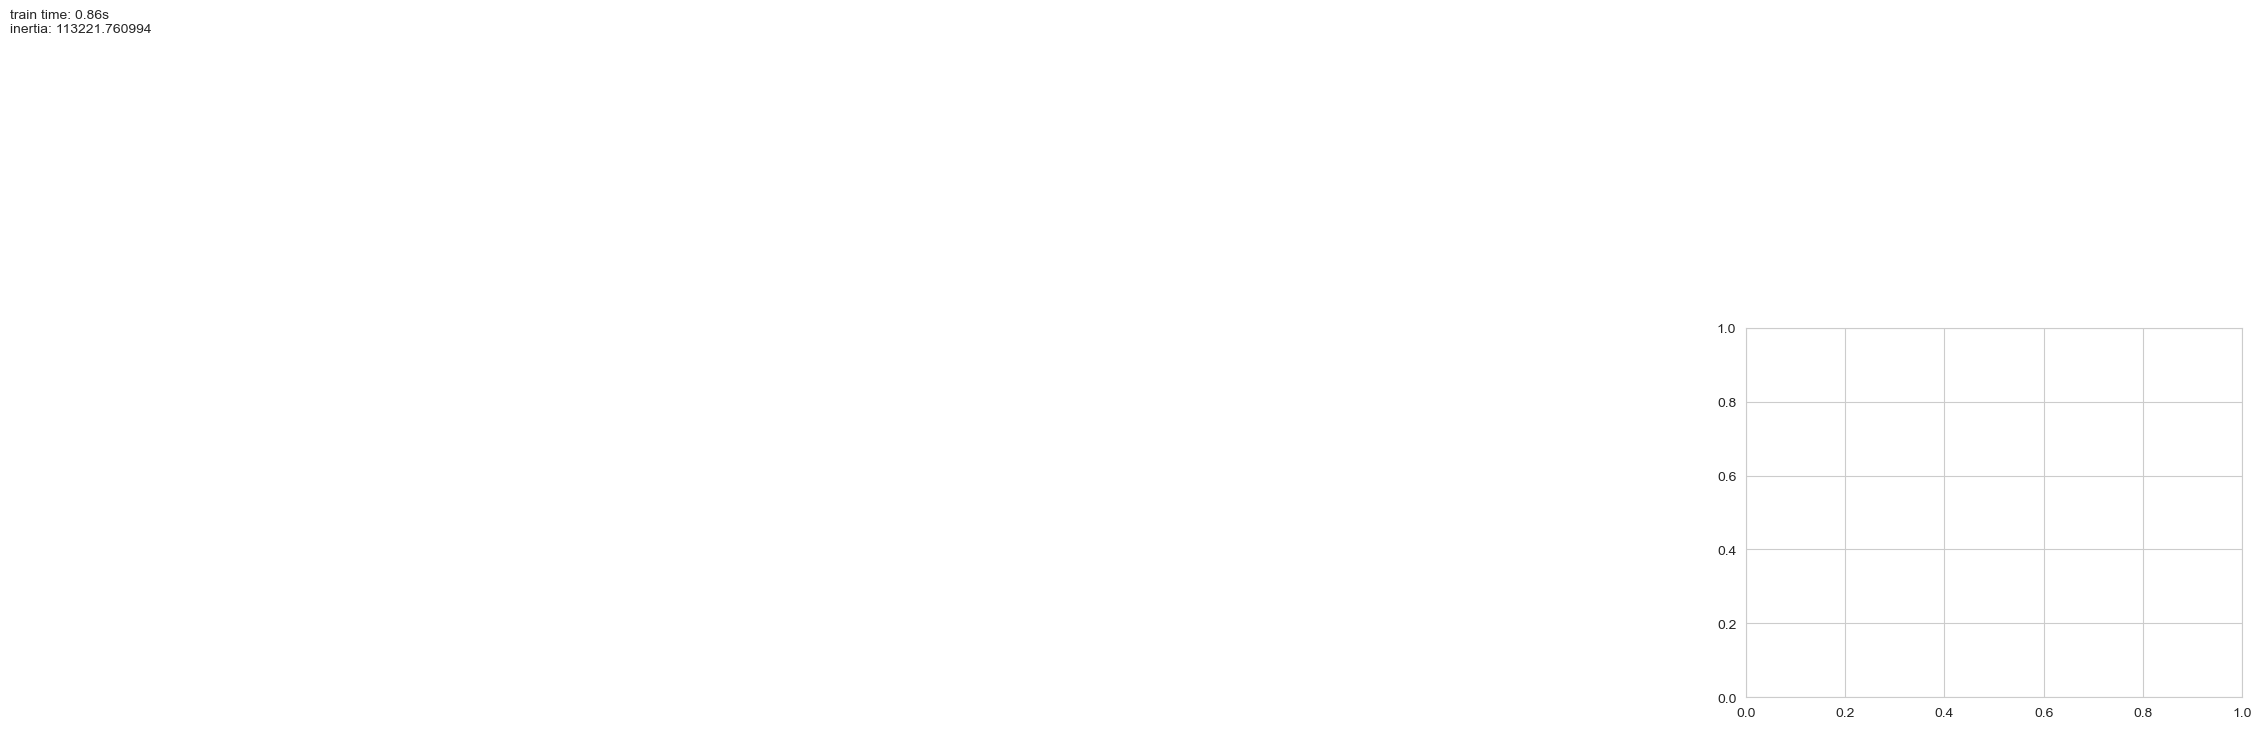

In [ ]:
# KMeans
ax = fig.add_subplot(1, 3, 1)
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], "w", markerfacecolor=col, marker=".")
    # ax.plot(
    #     cluster_center
    # )
    ax.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=6,
    )
ax.set_title("KMeans")
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8, "train time: %.2fs\ninertia: %f" % (t_batch, k_means.inertia_))

In [ ]:
k

2

In [ ]:
k_means_labels

array([ 1, 43, 47, ...,  0,  7,  1], dtype=int64)

In [ ]:
my_members

array([False, False, False, ..., False, False, False])

In [ ]:
cluster_center

array([2.21213572e-01, 2.71755166e+02])

In [ ]:
markerfacecolor=col

In [ ]:
col

'#4E9A06'

In [ ]:
markerfacecolor

'#4E9A06'

Text(-3.5, 1.8, 'train time: 1.18s\ninertia: 28930.169432')

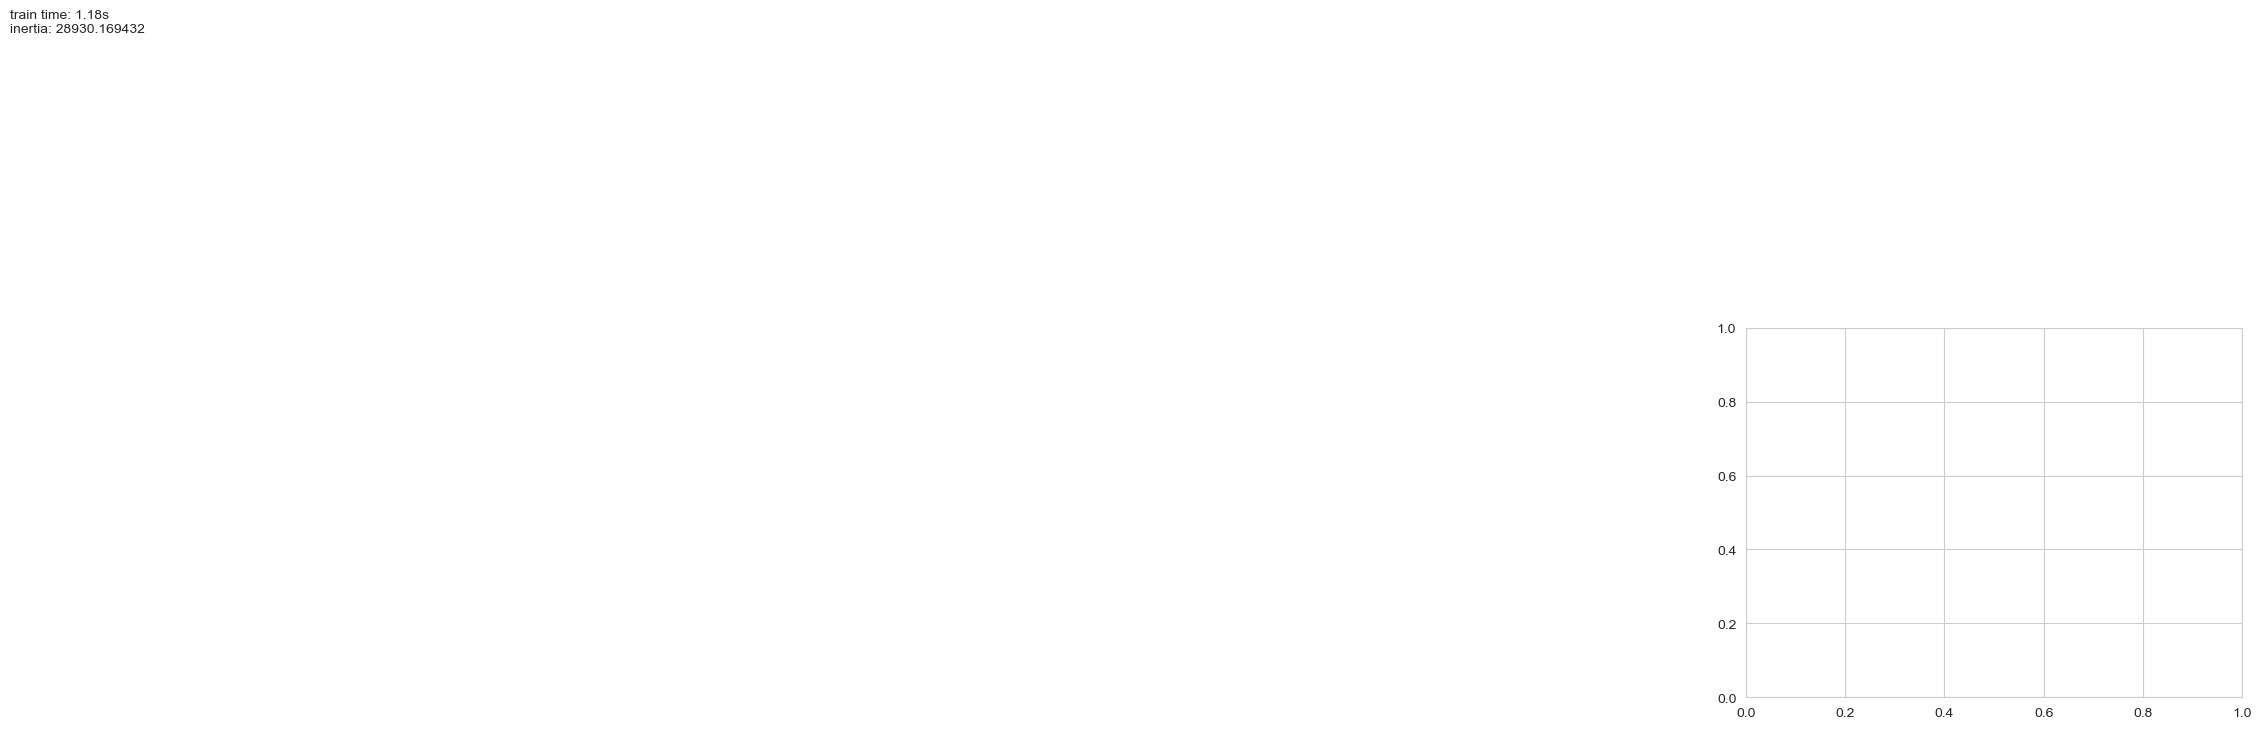

In [ ]:
# MiniBatchKMeans
ax = fig.add_subplot(1, 3, 2)
for k, col in zip(range(n_clusters), colors):
    my_members = mbk_means_labels == k
    cluster_center = mbk_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], "w", markerfacecolor=col, marker=".")
    ax.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=6,
    )
ax.set_title("MiniBatchKMeans")
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8, "train time: %.2fs\ninertia: %f" % (t_mini_batch, mbk.inertia_))

In [ ]:
# Initialize the different array to all False
different = mbk_means_labels == 4
ax = fig.add_subplot(1, 3, 3)

for k in range(n_clusters):
    different += (k_means_labels == k) != (mbk_means_labels == k)

identical = np.logical_not(different)
ax.plot(X[identical, 0], X[identical, 1], "w", markerfacecolor="#bbbbbb", marker=".")
ax.plot(X[different, 0], X[different, 1], "w", markerfacecolor="m", marker=".")
ax.set_title("Difference")
ax.set_xticks(())
ax.set_yticks(())

plt.show()